# Restaurant Graph Pipeline (fz dataset)

## Notebook Overview & Requirements

This notebook builds the full pipeline for the restaurant (fz) dataset or graph-based constraint/repair experiments :
- Clean raw ARFF and extract `area_code`
- Construct similarity edges based on `(addr, city)`
- Build graphs: constraint graph `S` and instance graph `G`
- Produce cleaned ground truth `G_opt` with no violations
- Persist artifacts for downstream perturbation/repair experiments
- Import to Neo4j and inject label noise.

Tips: tune `ADDRESS_DISTANCE_THRESHOLD` to control similarity density; ensure `.env` is set for Neo4j

## Setup & Tunable Parameters

- `ARFF_PATH`: path to input ARFF (FZ dataset).
- `OUTPUT_DIR`: destination for intermediate and cleaned artifacts.
- `ADDRESS_DISTANCE_THRESHOLD`: max edit distance for `addr` similarity within the same `city`.
- If `networkx` is available, graph stats/cleaning use it; otherwise a lightweight fallback is used.


In [16]:
# Setup and Parameters

# Imports
import os
from pathlib import Path
from datetime import datetime

import pandas as pd

# Edit distance
try:
    import Levenshtein
    def string_distance(a, b):
        return Levenshtein.distance(str(a), str(b))
except Exception as e:
    raise RuntimeError("python-Levenshtein is required; install via pyproject or pip.")

# Optional: NetworkX for convenience (graphs + stats)
try:
    import networkx as nx
    NX_AVAILABLE = True
except Exception:
    NX_AVAILABLE = False

# Parameters (tune as needed)
ARFF_PATH = Path("datasets/restaurant/fz.arff")
OUTPUT_DIR = Path("datasets/temp")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ADDRESS_DISTANCE_THRESHOLD = 7  # max edit distance for addr similarity

print("NetworkX available:", NX_AVAILABLE)
print("ARFF path:", ARFF_PATH)
print("Output dir:", OUTPUT_DIR)

NetworkX available: True
ARFF path: datasets\restaurant\fz.arff
Output dir: datasets\temp


## Load ARFF

- Parses the ARFF header to derive column names and reads the `@data` section into a DataFrame.
- Assumes a simple ARFF without sparse rows and with quoted strings.
- Output: `df` with columns including `name`, `phone`, `addr`, `city`

In [17]:
# Load ARFF into DataFrame
from io import StringIO

def arff_to_dataframe(filepath: Path) -> pd.DataFrame:
    data = False
    header = ""
    csv_content = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip('\n')
            if "@attribute" in line.lower():
                attributes = line.split()
                attri_idx = next(i for i, x in enumerate(attributes) if x.lower() == "@attribute")
                column_name = attributes[attri_idx + 1]
                header = header + column_name + ","
            elif "@data" in line.lower():
                data = True
                header = header.rstrip(',') + '\n'
                csv_content.append(header)
            elif data and line.strip():
                csv_content.append(line + '\n')
    csv_string = ''.join(csv_content)
    df_local = pd.read_csv(StringIO(csv_string), quotechar='"')
    return df_local

# Load
df = arff_to_dataframe(ARFF_PATH)
print(f"Loaded {len(df)} rows; columns: {list(df.columns)}")
df.head(3)

Loaded 864 rows; columns: ['name', 'addr', 'city', 'phone', 'type', 'class']


,name,addr,city,phone,type,class
0,arnie morton's of chicago,"""435 s. la cienega blv.""","""los angeles""","""310/246-1501""","""american""",'0'
1,arnie morton's of chicago,"""435 s. la cienega blvd.""","""los angeles""","""310-246-1501""","""steakhouses""",'0'
2,art's delicatessen,"""12224 ventura blvd.""","""studio city""","""818/762-1221""","""american""",'1'


## Enrich: Area Code

- Derives `area_code` from the first three digits of `phone` (after stripping separators).
- Validates expected columns: `name`, `phone`, `addr`, `city`.
- Output: `df` includes new `area_code` column (may be `None`).

In [18]:
# Extract area code and basic cleaning

def extract_area_code(phone):
    if pd.isna(phone) or phone is None:
        return None
    s = str(phone).strip().strip('"').strip("'")
    digits = s.replace('-', '').replace('/', '').replace(' ', '')
    if len(digits) >= 3 and digits[:3].isdigit():
        return digits[:3]
    return None

# Ensure expected columns exist
expected_cols = {"name", "phone", "addr", "city"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Compute area_code
df["area_code"] = df["phone"].apply(extract_area_code)

print("Area code extraction:")
print("  total:", len(df))
print("  with area_code:", df["area_code"].notna().sum())
print("  unique area_codes:", df["area_code"].nunique())

df[["name", "phone", "area_code"]].head(5)

Area code extraction:
  total: 864
  with area_code: 864
  unique area_codes: 11


,name,phone,area_code
0,arnie morton's of chicago,"""310/246-1501""",310
1,arnie morton's of chicago,"""310-246-1501""",310
2,art's delicatessen,"""818/762-1221""",818
3,art's deli,"""818-762-1221""",818
4,hotel bel-air,"""310/472-1211""",310


## Similarity Edges

- Builds undirected similarity edges where:
  - Restaurants share the same `city`, and
  - Levenshtein distance on `addr` is `< ADDRESS_DISTANCE_THRESHOLD`.
- Output: `similarity_edges` as list of `(i, j)` index pairs.
- Note: quadratic in N; acceptable for small datasets.


In [19]:
# Build similarity pairs based on (addr, city)

similarity_edges = []
N = len(df)
print(f"Building similarity pairs over {N} restaurants...")
for i in range(N):
    ai = df.iloc[i]
    for j in range(i+1, N):
        aj = df.iloc[j]
        if ai["city"] != aj["city"]:
            continue
        d = string_distance(ai["addr"], aj["addr"])
        if d < ADDRESS_DISTANCE_THRESHOLD:
            similarity_edges.append((i, j))

print("Similarity summary:")
print("  total edges:", len(similarity_edges))
if N:
    print("  avg degree:", (2*len(similarity_edges))/N)
print("Sample edges:", similarity_edges[:10])

Building similarity pairs over 864 restaurants...
Similarity summary:
  total edges: 5307
  avg degree: 12.284722222222221
Sample edges: [(0, 1), (0, 22), (0, 242), (1, 22), (1, 242), (2, 3), (2, 37), (2, 706), (3, 37), (3, 706)]


## Persist: Raw Graph Inputs

- Writes two files for downstream steps:
  - `restaurants_YYYYMMDD-HHMMSS.txt`: tab-separated `id, name, area_code, addr, city`.
  - `restaurant_similarities_YYYYMMDD-HHMMSS.txt`: one edge per line as `(i,j)`.
- These represent the uncleaned instance graph inputs.


In [20]:
# Persist cleaned temp outputs (raw graph inputs)

ts = datetime.now().strftime("%Y%m%d-%H%M%S")
restaurants_path = OUTPUT_DIR / f"restaurants_{ts}.txt"
similarities_path = OUTPUT_DIR / f"restaurant_similarities_{ts}.txt"

# Ensure area_code exists to avoid KeyError if earlier cell wasn't run
if "area_code" not in df.columns:
    def _extract_area_code_local(phone):
        if pd.isna(phone) or phone is None:
            return None
        s = str(phone).strip().strip('"').strip("'")
        digits = s.replace('-', '').replace('/', '').replace(' ', '')
        if len(digits) >= 3 and digits[:3].isdigit():
            return digits[:3]
        return None
    df["area_code"] = df["phone"].apply(_extract_area_code_local)

with open(restaurants_path, "w", encoding="utf-8") as f:
    f.write("id\tname\tarea_code\taddr\tcity\n")
    for idx, row in df.iterrows():
        f.write(f"{idx}\t{row['name']}\t{row['area_code']}\t{row['addr']}\t{row['city']}\n")

with open(similarities_path, "w", encoding="utf-8") as f:
    for i, j in similarity_edges:
        f.write(f"({i},{j})\n")

print("Saved:")
print("  ", restaurants_path)
print("  ", similarities_path)

Saved:
   datasets\temp\restaurants_20260127-171159.txt
   datasets\temp\restaurant_similarities_20260127-171159.txt


## Graphs & Cleaning

- Constraint graph `S`: nodes are `area_code` values; only self-loops are allowed (same-area connections).
- Instance graph `G`: nodes are restaurants (with `label = area_code`), edges from `similarity_edges`.
- Violation: an edge `(u, v)` where `label(u) != label(v)`.
- Cleaning: iteratively remove the lower-degree endpoint of the first found violating edge until none remain, producing `G_opt`.
- Outputs: pre/post statistics and number of removed nodes.

In [21]:
# Build graphs (S, G) and clean to ground truth (G_opt)

# Constraint graph S: nodes = area codes; only self-loops allowed
labels = sorted(df["area_code"].dropna().unique().tolist())

if NX_AVAILABLE:
    S = nx.Graph()
    S.add_nodes_from(labels)
    S.add_edges_from((ac, ac) for ac in labels)
else:
    S = {ac: {ac} for ac in labels}  # adjacency-by-label for checks

# Instance graph G: nodes = restaurant indices, label = area_code, edges from similarity pairs
if NX_AVAILABLE:
    G = nx.Graph()
    for idx, row in df.iterrows():
        G.add_node(int(idx))
        G.nodes[int(idx)]["label"] = row["area_code"]
        G.nodes[int(idx)]["name"] = row["name"]
        G.nodes[int(idx)]["addr"] = row["addr"]
        G.nodes[int(idx)]["city"] = row["city"]
    for u, v in similarity_edges:
        if u != v:
            G.add_edge(int(u), int(v))
else:
    # Lightweight structure without networkx
    G_nodes = {int(idx): {
        "label": row["area_code"],
        "name": row["name"],
        "addr": row["addr"],
        "city": row["city"],
    } for idx, row in df.iterrows()}
    G_edges = {(min(int(u), int(v)), max(int(u), int(v))) for (u, v) in similarity_edges if u != v}

# Violation check: neighbors must share same area_code

def has_edge_in_S(lu, lv):
    if NX_AVAILABLE:
        return S.has_edge(lu, lv)
    return lv in S.get(lu, set())

# Helpers to get the FIRST violating edge with respect to the CURRENT graph state
if NX_AVAILABLE:
    def first_violation(Gx):
        for (u, v) in Gx.edges():
            lu = Gx.nodes[u].get("label")
            lv = Gx.nodes[v].get("label")
            if not has_edge_in_S(lu, lv):
                return (u, v)
        return None

    def count_violations(Gx):
        c = 0
        for (u, v) in Gx.edges():
            lu = Gx.nodes[u].get("label")
            lv = Gx.nodes[v].get("label")
            if not has_edge_in_S(lu, lv):
                c += 1
        return c
else:
    def first_violation(_unused):
        for (u, v) in G_edges:
            lu = G_nodes[u]["label"]
            lv = G_nodes[v]["label"]
            if not has_edge_in_S(lu, lv):
                return (u, v)
        return None

    def count_violations_non_nx():
        c = 0
        for (u, v) in G_edges:
            lu = G_nodes[u]["label"]
            lv = G_nodes[v]["label"]
            if not has_edge_in_S(lu, lv):
                c += 1
        return c

# Cleaning: iteratively remove the lower-degree endpoint of first violation until none remain
removed = set()
if NX_AVAILABLE:
    G_opt = G.copy()
    viol_before = count_violations(G_opt)
    while True:
        pair = first_violation(G_opt)
        if not pair:
            break
        u, v = pair
        # Guard in case of transient references
        if u not in G_opt or v not in G_opt:
            continue
        drop = u if G_opt.degree[u] <= G_opt.degree[v] else v
        removed.add(drop)
        G_opt.remove_node(drop)
    viol_after = count_violations(G_opt)
else:
    # Non-NX cleaning
    viol_before = count_violations_non_nx()
    remaining_nodes = set(G_nodes.keys())
    while True:
        pair = first_violation(None)
        if not pair:
            break
        u, v = pair
        deg_u = sum(1 for e in G_edges if u in e)
        deg_v = sum(1 for e in G_edges if v in e)
        drop = u if deg_u <= deg_v else v
        removed.add(drop)
        remaining_nodes.discard(drop)
        G_edges = {e for e in G_edges if drop not in e}
    viol_after = count_violations_non_nx()

print("Graph stats (before cleaning):")
if NX_AVAILABLE:
    print(f"  |V|={len(G.nodes)}, |E|={len(G.edges)}")
else:
    print(f"  |V|={len(G_nodes)}, |E|={len(G_edges)}")

print("Cleaning results:")
print("  violations before:", viol_before)
print("  violations after:", viol_after)
print("  removed nodes:", len(removed))
if NX_AVAILABLE:
    print(f"  G_opt |V|={len(G_opt.nodes)}, |E|={len(G_opt.edges)}")
else:
    print(f"  G_opt |V|={len(remaining_nodes)}, |E|={len(G_edges)}")

Graph stats (before cleaning):
  |V|=864, |E|=5307
Cleaning results:
  violations before: 32
  violations after: 0
  removed nodes: 15
  G_opt |V|=849, |E|=5245


## Persist: Cleaned Ground Truth

- Writes `restaurants_cleaned_*.txt` and `restaurant_similarities_cleaned_*.txt`, mirroring the raw formats but restricted to `G_opt`.
- These files serve as the canonical, violation-free ground truth for experiments.

In [22]:
# Persist cleaned ground truth artifacts
ts2 = datetime.now().strftime("%Y%m%d-%H%M%S")
clean_restaurants_path = OUTPUT_DIR / f"restaurants_cleaned_{ts2}.txt"
clean_similarities_path = OUTPUT_DIR / f"restaurant_similarities_cleaned_{ts2}.txt"

# Helper to iterate nodes/edges in G_opt independent of NetworkX
if NX_AVAILABLE:
    nodes_iter = sorted(G_opt.nodes)
    edges_iter = sorted((min(u, v), max(u, v)) for (u, v) in G_opt.edges())
else:
    nodes_iter = sorted(remaining_nodes)
    edges_iter = sorted(G_edges)

# Map from id to row for writing attributes
by_id = {int(idx): row for idx, row in df.iterrows()}

with open(clean_restaurants_path, "w", encoding="utf-8") as f:
    f.write("id\tname\tarea_code\taddr\tcity\n")
    for rid in nodes_iter:
        r = by_id.get(int(rid))
        if r is None:
            continue
        f.write(f"{rid}\t{r['name']}\t{r['area_code']}\t{r['addr']}\t{r['city']}\n")

with open(clean_similarities_path, "w", encoding="utf-8") as f:
    for u, v in edges_iter:
        f.write(f"({u},{v})\n")

print("Saved cleaned ground truth:")
print("  ", clean_restaurants_path)
print("  ", clean_similarities_path)

Saved cleaned ground truth:
   datasets\temp\restaurants_cleaned_20260127-171200.txt
   datasets\temp\restaurant_similarities_cleaned_20260127-171200.txt


# Import into Neo4j

- Uses `.env` for: `NEO4J_URI`, `NEO4J_USERNAME`, `NEO4J_PASSWORD`, `NEO4J_CONSTRAINT_DB`, `NEO4J_INSTANCE_DB`.
- GT DB: loads `G_opt` (cleaned) and creates `AreaCode` nodes with self-loops via `:ALLOWED`.
- Instance DB: starts as a copy of GT (can be noised later).
- Validates that violations are zero after import.

### Neo4j Import Details

- Constraints: unique on `Restaurant(id)` and `AreaCode(code)`.
- Restaurants: properties `name`, `addr`, `city`, `area_code`, and `label = area_code`.
- Similarity: undirected similarity imported as two directed `:SIMILAR` relationships.
- Constraint graph `S`: collected distinct labels → `AreaCode` nodes with self `:ALLOWED` loops.

In [23]:
from dotenv import load_dotenv
from neo4j import GraphDatabase

# --- Env ---
env_path = Path.cwd() / ".env"
load_dotenv(dotenv_path=env_path, override=True)

def _strip_quotes(v):
    return None if v is None else v.strip().strip('"').strip("'")

URI = _strip_quotes(os.getenv("NEO4J_URI"))
USERNAME = _strip_quotes(os.getenv("NEO4J_USERNAME"))
PASSWORD = _strip_quotes(os.getenv("NEO4J_PASSWORD"))
GT_DB = _strip_quotes(os.getenv("NEO4J_CONSTRAINT_DB")) or "restaurants-gt"   # rename in your head: GT
INSTANCE_DB = _strip_quotes(os.getenv("NEO4J_INSTANCE_DB")) or "restaurants-instance"

AUTH = (USERNAME, PASSWORD)
print("Neo4j URI:", URI)
print("GT_DB:", GT_DB)
print("INSTANCE_DB:", INSTANCE_DB)

# --- Neo4j helpers ---
def clear_database(driver, database):
    driver.execute_query("MATCH (n) DETACH DELETE n", database_=database)

def setup_database(driver, database):
    driver.execute_query("""
        CREATE CONSTRAINT restaurant_id_unique IF NOT EXISTS
        FOR (r:Restaurant) REQUIRE r.id IS UNIQUE
    """, database_=database)

    driver.execute_query("""
        CREATE CONSTRAINT areacode_code_unique IF NOT EXISTS
        FOR (a:AreaCode) REQUIRE a.code IS UNIQUE
    """, database_=database)

def import_instance(driver, database, restaurants_list, edges_list):
    driver.execute_query("""
        UNWIND $restaurants AS r
        MERGE (n:Restaurant {id: r.id})
        SET n.name = r.name,
            n.addr = r.addr,
            n.city = r.city,
            n.area_code = r.area_code,
            n.label = r.area_code
    """, restaurants=restaurants_list, database_=database)

    # undirected SIMILAR as two directed edges
    driver.execute_query("""
        UNWIND $pairs AS p
        MATCH (a:Restaurant {id: p[0]})
        MATCH (b:Restaurant {id: p[1]})
        MERGE (a)-[:SIMILAR]->(b)
        MERGE (b)-[:SIMILAR]->(a)
    """, pairs=edges_list, database_=database)

def build_S(driver, database):
    driver.execute_query("""
        MATCH (r:Restaurant)
        WITH DISTINCT r.label AS code
        WHERE code IS NOT NULL
        MERGE (:AreaCode {code: code})
    """, database_=database)

    driver.execute_query("""
        MATCH (a:AreaCode)
        MERGE (a)-[:ALLOWED]->(a)
    """, database_=database)

def count_violations(driver, database):
    rec = driver.execute_query("""
        MATCH (a:Restaurant)-[:SIMILAR]->(b:Restaurant)
        WHERE a.label IS NOT NULL AND b.label IS NOT NULL AND a.label <> b.label
        RETURN count(*) AS v
    """, database_=database).records[0]
    return rec["v"]

# --- Load payloads from CLEANED ground-truth files (produced by cleaning notebook) ---
def load_clean_restaurants(path):
    rows = []
    with open(path, encoding="utf-8") as f:
        next(f)  # header
        for line in f:
            rid, name, area_code, addr, city = line.rstrip("\n").split("\t")
            rows.append({
                "id": str(rid),
                "name": name,
                "area_code": None if area_code in ("None", "") else area_code,
                "addr": addr,
                "city": city
            })
    return rows

def load_clean_edges(path):
    edges = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            s = line.strip().lstrip("(").rstrip(")")
            if not s:
                continue
            a, b = [x.strip() for x in s.split(",")]
            edges.append((str(a), str(b)))
    return edges

gt_restaurants = load_clean_restaurants(clean_restaurants_path)
gt_edges = load_clean_edges(clean_similarities_path)
print("GT payload:", len(gt_restaurants), "restaurants,", len(gt_edges), "edges")

# --- Run import ---
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Connected to Neo4j.")

    # GT_DB = cleaned G_opt
    clear_database(driver, GT_DB)
    setup_database(driver, GT_DB)
    import_instance(driver, GT_DB, gt_restaurants, gt_edges)
    build_S(driver, GT_DB)
    print("GT violations:", count_violations(driver, GT_DB), "(should be 0)")

    # INSTANCE_DB = exact copy of GT for now (noise later)
    clear_database(driver, INSTANCE_DB)
    setup_database(driver, INSTANCE_DB)
    import_instance(driver, INSTANCE_DB, gt_restaurants, gt_edges)
    build_S(driver, INSTANCE_DB)
    print("INSTANCE violations:", count_violations(driver, INSTANCE_DB), "(should be 0)")

print("Import done.")

Neo4j URI: neo4j://127.0.0.1:7687
GT_DB: restaurant-constraint
INSTANCE_DB: restaurant-instance
GT payload: 849 restaurants, 5245 edges
Connected to Neo4j.
GT violations: 0 (should be 0)
INSTANCE violations: 0 (should be 0)
Import done.


## Inject Label Noise (for experiments)

- Parameter `FRAUD_NUMBER` (e.g., `10` or `10x`) controls how many restaurants to relabel; parsed as digits only.
- Randomly selects `K` restaurants and changes their `label` to a different `AreaCode`.
- Annotates modified nodes with `:Fraudulent`, `noise_type = "label_noise"`, and `noise_old_label`.
- Reports violation count before/after to quantify injected inconsistency.
- Use `SEED` for reproducibility.

In [24]:
import random

# ---- Parameters ----
# Read FRAUD_NUMBER safely
raw_k = os.getenv("FRAUD_NUMBER", "10")
digits = "".join(ch for ch in raw_k if ch.isdigit())
K = int(digits) if digits else 10

SEED = 42  # reproducible noise
print("Using K =", K, " (from FRAUD_NUMBER =", raw_k, ")")
print("Using SEED =", SEED)

def fetch_restaurant_ids(driver, database):
    res = driver.execute_query("""
        MATCH (r:Restaurant)
        RETURN r.id AS id
        ORDER BY toInteger(r.id)
    """, database_=database)
    return [str(r["id"]) for r in res.records]

def fetch_area_codes(driver, database):
    res = driver.execute_query("""
        MATCH (a:AreaCode)
        RETURN a.code AS code
        ORDER BY a.code
    """, database_=database)
    return [str(r["code"]) for r in res.records]

def fetch_labels(driver, db):
    res = driver.execute_query("""
        MATCH (r:Restaurant)
        RETURN r.id AS id, r.label AS label
    """, database_=db)
    return {str(r["id"]): str(r["label"]) for r in res.records}

def inject_label_noise(driver, database, k, seed=42):
    rng = random.Random(seed)

    ids = fetch_restaurant_ids(driver, database)
    codes = fetch_area_codes(driver, database)

    if not ids:
        raise RuntimeError("No Restaurant nodes found.")
    if len(codes) < 2:
        raise RuntimeError("Need at least 2 distinct AreaCodes to inject label noise.")

    k = min(k, len(ids))
    chosen_ids = rng.sample(ids, k)

    # Fetch current labels for chosen nodes
    res = driver.execute_query("""
        UNWIND $ids AS id
        MATCH (r:Restaurant {id: id})
        RETURN r.id AS id, r.label AS old_label
    """, ids=chosen_ids, database_=database)

    updates = []
    for rec in res.records:
        rid = str(rec["id"])
        old = rec["old_label"]
        # choose a *different* label
        new = old
        while new == old:
            new = rng.choice(codes)
        updates.append({"id": rid, "old_label": old, "new_label": new})

    # Apply updates
    driver.execute_query("""
        UNWIND $updates AS u
        MATCH (r:Restaurant {id: u.id})
        SET r.noise_old_label = u.old_label,
            r.label = u.new_label,
            r.noise_type = "label_noise"
        SET r:Fraudulent
    """, updates=updates, database_=database)

    return updates

def count_violations(driver, database):
    rec = driver.execute_query("""
        MATCH (a:Restaurant)-[:SIMILAR]->(b:Restaurant)
        WHERE a.label IS NOT NULL AND b.label IS NOT NULL AND a.label <> b.label
        RETURN count(*) AS v
    """, database_=database).records[0]
    return int(rec["v"])

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    # Safety: INSTANCE should start clean
    v0 = count_violations(driver, INSTANCE_DB)
    print("INSTANCE violations BEFORE noise:", v0)

    updates = inject_label_noise(driver, INSTANCE_DB, K, seed=SEED)
    inst_before_labels = fetch_labels(driver, INSTANCE_DB)
    viol_before = count_violations(driver, INSTANCE_DB)
    
    print(f"Injected label noise into {len(updates)} restaurants.")

    v1 = count_violations(driver, INSTANCE_DB)
    print("INSTANCE violations AFTER noise:", v1)

    # Quick peek: show a few modified nodes
    sample = updates[:10]
    print("Sample updates:", sample)

Using K = 50  (from FRAUD_NUMBER = 50 )
Using SEED = 42
INSTANCE violations BEFORE noise: 0
Injected label noise into 50 restaurants.
INSTANCE violations AFTER noise: 986
Sample updates: [{'id': '668', 'old_label': '213', 'new_label': '805'}, {'id': '123', 'old_label': '212', 'new_label': '404'}, {'id': '34', 'old_label': '213', 'new_label': '100'}, {'id': '773', 'old_label': '702', 'new_label': '718'}, {'id': '295', 'old_label': '212', 'new_label': '770'}, {'id': '264', 'old_label': '310', 'new_label': '212'}, {'id': '238', 'old_label': '818', 'new_label': '702'}, {'id': '151', 'old_label': '404', 'new_label': '212'}, {'id': '768', 'old_label': '702', 'new_label': '770'}, {'id': '113', 'old_label': '718', 'new_label': '404'}]


## Pre-Repair Diagnostics (Instance vs Ground Truth)
Summarize injected noise and baseline inconsistencies before repair.


In [25]:
# Pre-Repair Diagnostics (Instance vs Ground Truth)
def count_violations(driver, database):
    rec = driver.execute_query("""
        MATCH (a:Restaurant)-[:SIMILAR]->(b:Restaurant)
        WHERE a.label IS NOT NULL AND b.label IS NOT NULL AND a.label <> b.label
        RETURN count(*) AS v
    """, database_=database).records[0]
    return int(rec["v"])

def count_wrong_labels_vs_gt(driver, gt_db, inst_db):
    gt = driver.execute_query("MATCH (r:Restaurant) RETURN r.id AS id, r.label AS l", database_=gt_db).records
    inst = driver.execute_query("MATCH (r:Restaurant) RETURN r.id AS id, r.label AS l", database_=inst_db).records
    gt_map = {str(r["id"]): str(r["l"]) for r in gt}
    inst_map = {str(r["id"]): str(r["l"]) for r in inst}
    common = set(gt_map) & set(inst_map)
    wrong = [rid for rid in common if gt_map[rid] != inst_map[rid]]
    return len(wrong)

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print({
        "k_fraud": driver.execute_query("MATCH (r:Restaurant:Fraudulent) RETURN count(r) AS c", database_=INSTANCE_DB).records[0]["c"],
        "violations_before_repair": count_violations(driver, INSTANCE_DB),
        "wrong_labels_vs_gt": count_wrong_labels_vs_gt(driver, GT_DB, INSTANCE_DB),
    })


{'k_fraud': 50, 'violations_before_repair': 986, 'wrong_labels_vs_gt': 50}


## Greedy Repair (Neighborhood-Consistent Relabeling)

- Purpose: reduce SIMILAR-edge label violations in `INSTANCE_DB` caused by injected noise.
- Approach:
    - Repeatedly pick the node with the highest number of violating outgoing edges.
    - Relabel it to the majority label among its SIMILAR neighbors (tie-break: lexicographic).
    - If the majority equals the current label, try the second-best label; otherwise stop.
- Parameters:
    - `MAX_STEPS`: max relabel operations.
    - `PRINT_EVERY`: step logging frequency.
- Functions:
    - `count_violations()`: returns total violating edges.
    - `pick_worst_node()`: finds node with largest violating out-degree.
    - `majority_neighbor_label(rid)`: best neighbor label and its support.
    - `apply_relabel(rid, new_label)`: sets `r.repair_old_label`, updates `r.label`, and tags `r.repaired = true`.
    - `greedy_repair_restaurants(...)`: orchestrates the loop and records a `history` of steps.
- Stopping conditions:
    - No violations remain.
    - Target node has no labeled neighbors.
    - Violations do not decrease after a step.
    - Step limit reached.
- Outputs:
    - Console logs: start/step/stop messages and violation counts.
    - `history`: per-step records (`id`, `bad_degree`, `old_label`, `new_label`, `neighbor_support`, `violations`).

In [26]:
# --- Greedy Repair Algorithm ---
MAX_STEPS = 200
PRINT_EVERY = 1  # set to 5/10 if too chatty

def count_violations(driver, database):
    rec = driver.execute_query("""
        MATCH (a:Restaurant)-[:SIMILAR]->(b:Restaurant)
        WHERE a.label IS NOT NULL AND b.label IS NOT NULL AND a.label <> b.label
        RETURN count(*) AS v
    """, database_=database).records[0]
    return int(rec["v"])

def pick_worst_node(driver, database):
    """
    Returns (id, label, bad_degree) for the node with highest violating out-edges.
    """
    res = driver.execute_query("""
        MATCH (r:Restaurant)-[:SIMILAR]->(n:Restaurant)
        WHERE r.label IS NOT NULL AND n.label IS NOT NULL AND r.label <> n.label
        WITH r, count(*) AS bad_degree
        ORDER BY bad_degree DESC, toInteger(r.id) ASC
        LIMIT 1
        RETURN r.id AS id, r.label AS label, bad_degree
    """, database_=database)
    if not res.records:
        return None
    rec = res.records[0]
    return str(rec["id"]), str(rec["label"]), int(rec["bad_degree"])

def majority_neighbor_label(driver, database, rid):
    """
    Find the most frequent neighbor label among SIMILAR neighbors of r.
    Tie-break: lexicographic label.
    """
    res = driver.execute_query("""
        MATCH (r:Restaurant {id: $rid})-[:SIMILAR]->(n:Restaurant)
        WHERE n.label IS NOT NULL
        WITH n.label AS lab, count(*) AS c
        ORDER BY c DESC, lab ASC
        LIMIT 1
        RETURN lab AS best_label, c AS support
    """, rid=rid, database_=database)
    if not res.records:
        return None
    rec = res.records[0]
    return str(rec["best_label"]), int(rec["support"])

def apply_relabel(driver, database, rid, new_label):
    driver.execute_query("""
        MATCH (r:Restaurant {id: $rid})
        SET r.repair_old_label = r.label,
            r.label = $new_label,
            r.repaired = true
    """, rid=rid, new_label=new_label, database_=database)

def greedy_repair_restaurants(driver, database, max_steps=200, print_every=1):
    history = []
    v_prev = count_violations(driver, database)
    print(f"Start violations: {v_prev}")

    for step in range(1, max_steps + 1):
        picked = pick_worst_node(driver, database)
        if picked is None:
            print("No violations left. Stop.")
            break

        rid, cur_label, bad_degree = picked
        maj = majority_neighbor_label(driver, database, rid)
        if maj is None:
            # isolated node or no labeled neighbors; can't help
            print(f"[{step}] id={rid}: no neighbors with labels; stop.")
            break

        best_label, support = maj

        if best_label == cur_label:
            # Already matches neighbor majority, but still violating: can happen with ties/structure.
            # In this case, try the 2nd best label as a fallback.
            res2 = driver.execute_query("""
                MATCH (r:Restaurant {id: $rid})-[:SIMILAR]->(n:Restaurant)
                WHERE n.label IS NOT NULL
                WITH n.label AS lab, count(*) AS c
                ORDER BY c DESC, lab ASC
                SKIP 1 LIMIT 1
                RETURN lab AS second_label, c AS support
            """, rid=rid, database_=database)
            if res2.records:
                best_label = str(res2.records[0]["second_label"])
                support = int(res2.records[0]["support"])
            else:
                # nothing else to try
                print(f"[{step}] id={rid}: majority label equals current and no alternative; stop.")
                break

        apply_relabel(driver, database, rid, best_label)

        v_now = count_violations(driver, database)
        history.append({
            "step": step,
            "id": rid,
            "bad_degree": bad_degree,
            "old_label": cur_label,
            "new_label": best_label,
            "neighbor_support": support,
            "violations": v_now
        })

        if step % print_every == 0:
            print(f"[{step}] id={rid} bad={bad_degree} {cur_label}->{best_label} | violations {v_prev}->{v_now}")

        # Stop if not improving
        if v_now >= v_prev:
            print(f"Stop: violations did not decrease (prev={v_prev}, now={v_now}).")
            break

        v_prev = v_now

    return history

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()    
    hist = greedy_repair_restaurants(driver, INSTANCE_DB, max_steps=MAX_STEPS, print_every=PRINT_EVERY)
    inst_after_labels = fetch_labels(driver, INSTANCE_DB)
    viol_after = count_violations(driver, INSTANCE_DB)
    

print(f"Greedy steps applied: {len(hist)}")
print("Violations AFTER repair:", viol_after)
print("Last 5 steps:", hist[-5:] if hist else hist)

Start violations: 986
[1] id=104 bad=76 404->212 | violations 986->840
[2] id=298 bad=71 805->212 | violations 840->700
[3] id=443 bad=50 818->212 | violations 700->606
[4] id=446 bad=49 100->212 | violations 606->512
[5] id=366 bad=47 415->212 | violations 512->420
[6] id=403 bad=45 100->212 | violations 420->330
[7] id=768 bad=28 770->702 | violations 330->276
[8] id=773 bad=28 718->702 | violations 276->220
[9] id=103 bad=17 415->212 | violations 220->186
[10] id=212 bad=15 213->415 | violations 186->156
[11] id=630 bad=11 404->415 | violations 156->134
[12] id=151 bad=8 212->404 | violations 134->118
[13] id=772 bad=7 415->702 | violations 118->104
[14] id=172 bad=6 213->404 | violations 104->92
[15] id=168 bad=4 818->404 | violations 92->84
[16] id=617 bad=4 818->415 | violations 84->76
[17] id=618 bad=4 212->415 | violations 76->68
[18] id=843 bad=4 818->415 | violations 68->60
[19] id=123 bad=3 404->212 | violations 60->54
[20] id=233 bad=3 212->310 | violations 54->48
[21] id=7

In [27]:
# --- Evaluation: label recovery vs GT using BEFORE and AFTER snapshots ---

def evaluate_label_recovery(gt_labels, before_labels, after_labels):
    common = set(gt_labels) & set(before_labels) & set(after_labels)

    # Nodes truly corrupted by injection (wrong before repair)
    true_wrong = {rid for rid in common if before_labels[rid] != gt_labels[rid]}

    # Nodes wrong after repair
    wrong_after = {rid for rid in common if after_labels[rid] != gt_labels[rid]}

    # Fixed nodes (were wrong before, correct after)
    fixed = true_wrong - wrong_after

    # Collateral damage (were correct before, became wrong after)
    broken = (common - true_wrong) & wrong_after

    TP = len(fixed)
    FN = len(true_wrong & wrong_after)   # still wrong
    FP = len(broken)                    # newly broken

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0
    f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0

    acc_after = (len(common) - len(wrong_after)) / len(common) if common else 0.0

    return {
        "nodes_compared": len(common),
        "true_wrong_before": len(true_wrong),
        "wrong_after": len(wrong_after),
        "fixed": len(fixed),
        "broken": len(broken),
        "TP_fixed": TP,
        "FP_broken": FP,
        "FN_not_fixed": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "label_accuracy_after": acc_after,
    }

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    gt_labels = fetch_labels(driver, GT_DB)
    
metrics = evaluate_label_recovery(gt_labels, inst_before_labels, inst_after_labels)

summary = {
    "k_injected": K,
    "violations_before": viol_before,
    "violations_after": viol_after,
    "repair_cost_num_relabels": len(hist),
    **metrics
}

print("Evaluation summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

Evaluation summary:
  k_injected: 50
  violations_before: 986
  violations_after: 10
  repair_cost_num_relabels: 30
  nodes_compared: 849
  true_wrong_before: 50
  wrong_after: 22
  fixed: 29
  broken: 1
  TP_fixed: 29
  FP_broken: 1
  FN_not_fixed: 21
  precision: 0.9666666666666667
  recall: 0.58
  f1: 0.725
  label_accuracy_after: 0.9740871613663133


In [29]:
# --- Full Experiment: varying K and collecting results ---
Ks = [5, 10, 20, 50]
SEED = 42
MAX_STEPS = 200

def reset_instance(driver):
    clear_database(driver, INSTANCE_DB)
    setup_database(driver, INSTANCE_DB)
    import_instance(driver, INSTANCE_DB, gt_restaurants, gt_edges)
    build_S(driver, INSTANCE_DB)

rows = []

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    gt_labels = fetch_labels(driver, GT_DB)

    for k in Ks:
        reset_instance(driver)

        inject_label_noise(driver, INSTANCE_DB, k, seed=SEED)
        inst_before_labels = fetch_labels(driver, INSTANCE_DB)
        viol_before = count_violations(driver, INSTANCE_DB)

        hist = greedy_repair_restaurants(driver, INSTANCE_DB, max_steps=MAX_STEPS, print_every=10**9)
        inst_after_labels = fetch_labels(driver, INSTANCE_DB)
        viol_after = count_violations(driver, INSTANCE_DB)

        metrics = evaluate_label_recovery(gt_labels, inst_before_labels, inst_after_labels)

        rows.append({
            "k": k,
            "seed": SEED,
            "violations_before": viol_before,
            "violations_after": viol_after,
            "repair_cost_num_relabels": len(hist),
            **metrics
        })

df_results = pd.DataFrame(rows).sort_values("k")
df_results


Start violations: 66
No violations left. Stop.
Start violations: 136
No violations left. Stop.
Start violations: 428
No violations left. Stop.
Start violations: 986
Stop: violations did not decrease (prev=10, now=10).


,k,seed,violations_before,violations_after,repair_cost_num_relabels,nodes_compared,true_wrong_before,wrong_after,fixed,broken,TP_fixed,FP_broken,FN_not_fixed,precision,recall,f1,label_accuracy_after
0,5,42,66,0,3,849,5,2,3,0,3,0,2,1.000000,0.60,0.750000,0.997644
1,10,42,136,0,5,849,10,5,5,0,5,0,5,1.000000,0.50,0.666667,0.994111
2,20,42,428,0,14,849,20,6,14,0,14,0,6,1.000000,0.70,0.823529,0.992933
3,50,42,986,10,30,849,50,22,29,1,29,1,21,0.966667,0.58,0.725000,0.974087


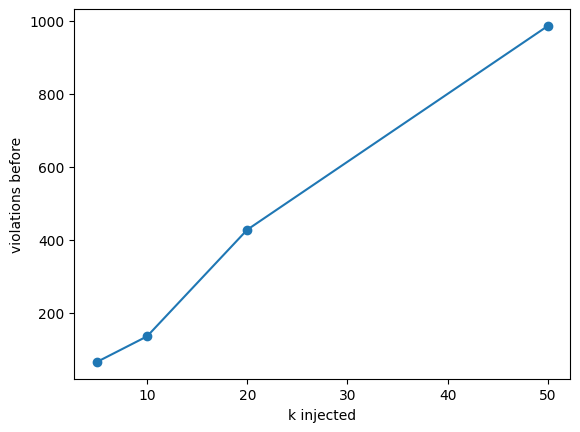

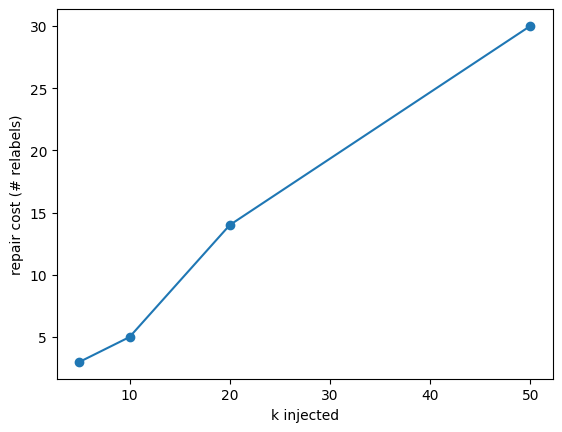

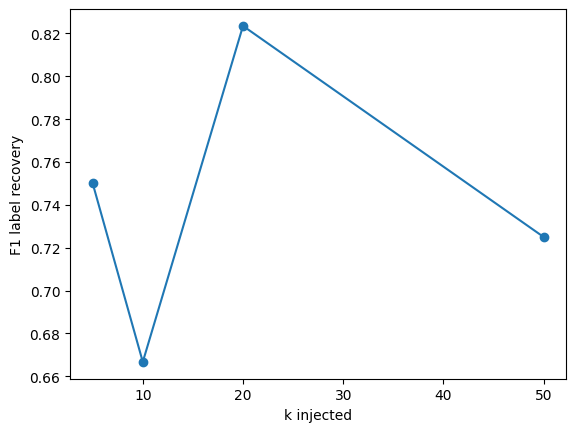

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results["k"], df_results["violations_before"], marker="o")
plt.xlabel("k injected")
plt.ylabel("violations before")
plt.show()

plt.figure()
plt.plot(df_results["k"], df_results["repair_cost_num_relabels"], marker="o")
plt.xlabel("k injected")
plt.ylabel("repair cost (# relabels)")
plt.show()

plt.figure()
plt.plot(df_results["k"], df_results["f1"], marker="o")
plt.xlabel("k injected")
plt.ylabel("F1 label recovery")
plt.show()


In [35]:
# =========================
# Compare 3 Greedy variants on Restaurants
#  (A) Your current heuristic greedy (majority-neighbor on worst node)
#  (B) Paper-ish Greedy V1 (worst node, choose label minimizing T(v,l) via neighbor-label counts)
#  (C) Paper-ish Greedy V2 (global best action by gain each step)
#
# Output: a single DataFrame with metrics for each (k, algorithm)
# =========================

import pandas as pd
from neo4j import GraphDatabase

# ---------- 0) REQUIRED: you already have these from earlier cells ----------
# URI, AUTH, GT_DB, INSTANCE_DB
# gt_restaurants, gt_edges
# clear_database, setup_database, import_instance, build_S
# inject_label_noise, fetch_labels, count_violations (Neo4j version), evaluate_label_recovery
#
# Also: your existing greedy function (your heuristic):
#   greedy_repair_restaurants(driver, INSTANCE_DB, max_steps=..., print_every=...)
# Make sure it supports print_every=0 OR set a huge print_every here.

# ---------- 1) Reset instance to clean GT payload ----------
def reset_instance(driver):
    clear_database(driver, INSTANCE_DB)
    setup_database(driver, INSTANCE_DB)
    import_instance(driver, INSTANCE_DB, gt_restaurants, gt_edges)
    build_S(driver, INSTANCE_DB)

# ---------- 2) Greedy V1 (Restaurants-smart, Neo4j) ----------
def greedy_v1_restaurants(driver, db, max_steps=200, print_every=None):
    """
    Paper V1 spirit:
      - pick vertex with max violating incident edges
      - pick label minimizing T(v,l)
    For Restaurants equality constraint, minimizing T(v,l) == choose neighbor label with max support.
    """
    history = []
    v_prev = count_violations(driver, db)

    for step in range(1, max_steps + 1):
        # worst node by violating out-edges
        res = driver.execute_query("""
            MATCH (r:Restaurant)-[:SIMILAR]->(n:Restaurant)
            WHERE r.label IS NOT NULL AND n.label IS NOT NULL AND r.label <> n.label
            WITH r, count(*) AS bad_degree
            ORDER BY bad_degree DESC, toInteger(r.id) ASC
            LIMIT 1
            RETURN r.id AS id, r.label AS old_label, bad_degree
        """, database_=db)

        if not res.records:
            break  # no violations left

        rid = str(res.records[0]["id"])
        old_label = str(res.records[0]["old_label"])
        bad_degree = int(res.records[0]["bad_degree"])

        best = driver.execute_query("""
            MATCH (r:Restaurant {id: $rid})-[:SIMILAR]->(n:Restaurant)
            WHERE n.label IS NOT NULL
            WITH n.label AS cand, count(*) AS support
            ORDER BY support DESC, cand ASC
            LIMIT 1
            RETURN cand AS best_label, support
        """, rid=rid, database_=db)

        if not best.records:
            break

        new_label = str(best.records[0]["best_label"])
        support = int(best.records[0]["support"])

        if new_label == old_label:
            break

        driver.execute_query("""
            MATCH (r:Restaurant {id: $rid})
            SET r.repair_old_label = r.label,
                r.label = $new_label,
                r.repaired = true,
                r.repair_algo = "greedy_v1"
        """, rid=rid, new_label=new_label, database_=db)

        v_now = count_violations(driver, db)
        history.append({
            "step": step, "id": rid,
            "bad_degree": bad_degree,
            "old_label": old_label,
            "new_label": new_label,
            "neighbor_support": support,
            "violations": v_now
        })

        # stop if not improving
        if v_now >= v_prev:
            break
        v_prev = v_now

        if print_every and step % print_every == 0:
            print(f"[V1 {step}] {rid} {old_label}->{new_label} violations={v_now}")

    return history

# ---------- 3) Greedy V2 (Restaurants-smart, Neo4j) ----------
def greedy_v2_restaurants(driver, db, max_steps=200, print_every=None):
    history = []
    v_prev = count_violations(driver, db)

    for step in range(1, max_steps + 1):
        res = driver.execute_query("""
            MATCH (r:Restaurant)-[:SIMILAR]->(n:Restaurant)
            WHERE r.label IS NOT NULL AND n.label IS NOT NULL
            WITH r,
                 n.label AS nl,
                 count(*) AS support,
                 COUNT { (r)-[:SIMILAR]->(:Restaurant) } AS deg
            WITH r, deg, collect({lab:nl, c:support}) AS counts
            WITH r, deg,
                 reduce(best={lab:r.label, c:0}, x IN counts |
                        CASE WHEN x.c > best.c OR (x.c = best.c AND x.lab < best.lab)
                             THEN x ELSE best END) AS bestCand
            MATCH (r)-[:SIMILAR]->(m:Restaurant)
            WHERE m.label IS NOT NULL AND m.label <> r.label
            WITH r, deg, bestCand, count(m) AS cur_bad
            WITH r,
                 cur_bad,
                 bestCand.lab AS new_label,
                 (deg - bestCand.c) AS new_bad,
                 (cur_bad - (deg - bestCand.c)) AS gain
            WHERE gain > 0 AND new_label <> r.label
            ORDER BY gain DESC, toInteger(r.id) ASC
            LIMIT 1
            RETURN r.id AS id, r.label AS old_label, new_label, gain, cur_bad
        """, database_=db)

        if not res.records:
            break

        rec = res.records[0]
        rid = str(rec["id"])
        old_label = str(rec["old_label"])
        new_label = str(rec["new_label"])
        gain = int(rec["gain"])
        cur_bad = int(rec["cur_bad"])

        driver.execute_query("""
            MATCH (r:Restaurant {id: $rid})
            SET r.repair_old_label = r.label,
                r.label = $new_label,
                r.repaired = true,
                r.repair_algo = "greedy_v2"
        """, rid=rid, new_label=new_label, database_=db)

        v_now = count_violations(driver, db)
        history.append({
            "step": step, "id": rid,
            "old_label": old_label,
            "new_label": new_label,
            "gain": gain,
            "cur_bad": cur_bad,
            "violations": v_now
        })

        if v_now >= v_prev:
            break
        v_prev = v_now

        if print_every and step % print_every == 0:
            print(f"[V2 {step}] {rid} {old_label}->{new_label} gain={gain} violations={v_now}")

        if v_now == 0:
            break

    return history


# ---------- 4) Wrapper for existing heuristic greedy ----------
def run_greedy_heuristic(driver, db, max_steps=200):
    # IMPORTANT: your greedy_repair_restaurants must not crash on print_every=0
    # If it does, pass a huge number instead.
    try:
        return greedy_repair_restaurants(driver, db, max_steps=max_steps, print_every=10**9)
    except TypeError:
        # if your function signature differs, adjust here
        return greedy_repair_restaurants(driver, db, max_steps=max_steps)

# ---------- 5) One run for one algorithm ----------
def run_one_algorithm(driver, algo_name, k, seed, max_steps):
    # reset clean
    reset_instance(driver)

    # noise + snapshot
    inject_label_noise(driver, INSTANCE_DB, k, seed=seed)
    inst_before = fetch_labels(driver, INSTANCE_DB)
    viol_before = count_violations(driver, INSTANCE_DB)

    # repair + snapshot
    if algo_name == "heuristic":
        hist = run_greedy_heuristic(driver, INSTANCE_DB, max_steps=max_steps)
    elif algo_name == "greedy_v1":
        hist = greedy_v1_restaurants(driver, INSTANCE_DB, max_steps=max_steps, print_every=None)
    elif algo_name == "greedy_v2":
        hist = greedy_v2_restaurants(driver, INSTANCE_DB, max_steps=max_steps, print_every=None)
    else:
        raise ValueError(f"Unknown algo_name: {algo_name}")

    inst_after = fetch_labels(driver, INSTANCE_DB)
    viol_after = count_violations(driver, INSTANCE_DB)

    metrics = evaluate_label_recovery(gt_labels, inst_before, inst_after)

    return {
        "algo": algo_name,
        "k": k,
        "seed": seed,
        "violations_before": viol_before,
        "violations_after": viol_after,
        "repair_cost_num_relabels": len(hist),
        **metrics
    }

# ---------- 6) Run comparison grid ----------
ALGOS = ["heuristic", "greedy_v1", "greedy_v2"]
Ks = [5, 10, 20, 50]
SEED = 42
MAX_STEPS = 200

rows = []
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    # GT labels are stable; fetch once
    gt_labels = fetch_labels(driver, GT_DB)

    for k in Ks:
        for algo in ALGOS:
            row = run_one_algorithm(driver, algo, k, SEED, MAX_STEPS)
            rows.append(row)
            print(f"done: algo={algo} k={k} | before={row['violations_before']} after={row['violations_after']} f1={row['f1']:.3f}")

df_compare = pd.DataFrame(rows).sort_values(["k", "algo"]).reset_index(drop=True)
df_compare


Start violations: 66
No violations left. Stop.
done: algo=heuristic k=5 | before=66 after=0 f1=0.750
done: algo=greedy_v1 k=5 | before=66 after=0 f1=0.750
done: algo=greedy_v2 k=5 | before=66 after=0 f1=0.750
Start violations: 136
No violations left. Stop.
done: algo=heuristic k=10 | before=136 after=0 f1=0.667
done: algo=greedy_v1 k=10 | before=136 after=0 f1=0.667
done: algo=greedy_v2 k=10 | before=136 after=0 f1=0.667
Start violations: 428
No violations left. Stop.
done: algo=heuristic k=20 | before=428 after=0 f1=0.824
done: algo=greedy_v1 k=20 | before=428 after=0 f1=0.824
done: algo=greedy_v2 k=20 | before=428 after=0 f1=0.824
Start violations: 986
Stop: violations did not decrease (prev=10, now=10).
done: algo=heuristic k=50 | before=986 after=10 f1=0.725
done: algo=greedy_v1 k=50 | before=986 after=10 f1=0.734
done: algo=greedy_v2 k=50 | before=986 after=0 f1=0.795


,algo,k,seed,violations_before,violations_after,repair_cost_num_relabels,nodes_compared,true_wrong_before,wrong_after,fixed,broken,TP_fixed,FP_broken,FN_not_fixed,precision,recall,f1,label_accuracy_after
0,greedy_v1,5,42,66,0,3,849,5,2,3,0,3,0,2,1.000000,0.60,0.750000,0.997644
1,greedy_v2,5,42,66,0,3,849,5,2,3,0,3,0,2,1.000000,0.60,0.750000,0.997644
2,heuristic,5,42,66,0,3,849,5,2,3,0,3,0,2,1.000000,0.60,0.750000,0.997644
3,greedy_v1,10,42,136,0,5,849,10,5,5,0,5,0,5,1.000000,0.50,0.666667,0.994111
4,greedy_v2,10,42,136,0,5,849,10,5,5,0,5,0,5,1.000000,0.50,0.666667,0.994111
5,heuristic,10,42,136,0,5,849,10,5,5,0,5,0,5,1.000000,0.50,0.666667,0.994111
6,greedy_v1,20,42,428,0,14,849,20,6,14,0,14,0,6,1.000000,0.70,0.823529,0.992933
7,greedy_v2,20,42,428,0,14,849,20,6,14,0,14,0,6,1.000000,0.70,0.823529,0.992933
8,heuristic,20,42,428,0,14,849,20,6,14,0,14,0,6,1.000000,0.70,0.823529,0.992933
9,greedy_v1,50,42,986,10,29,849,50,21,29,0,29,0,21,1.000000,0.58,0.734177,0.975265
